# Doing More with Data: `pandas`

# Contents:

1. Setup
2. Intro to `pandas`
2. Getting data
3. Profiling and initial data exploration: changing data types, descriptive statistics
4. Wrangling and plotting: concatenating, merging, adding and removing columns, filtering and selecting, null values, grouping and aggregating, plotting
5. Writing to file
6. More wrangling: reshaping, applying functions

## Data

This module uses four datasets: [bike thefts](https://open.toronto.ca/dataset/bicycle-thefts/), [TTC subway delays and subway delay reason codes](https://open.toronto.ca/dataset/ttc-subway-delay-data/), and [neighbourhood profiles](https://open.toronto.ca/dataset/neighbourhood-profiles/). All four are available in the course repo, and originally come from Toronto Open Data.

The specific file names are:
- bicycle-thefts - 4326.csv
- ttc-subway-delay-data-2021.xlsx
- ttc-subway-delay-codes.xlsx
- neighbourhood-profiles-2016-140-model.csv

# `pandas`

## What is `pandas`?

`pandas` is a package for data analysis and manipulation. (The name is a reference to panel data, not the animal.) It gives us data frames, which represent data in a table of columns and rows, and functions to manipulate and plot them. `pandas` also provides a slew of functions for reading and writing data to a variety of sources, including files, SQL databases, and compressed binary formats.

In [ ]:
# If there are issues with library installation please type the following commands into Terminal:

# conda install pandas

In [ ]:
import numpy as np
# pd is the conventional alias for pandas
import pandas as pd

# display all columns
pd.set_option("display.max_columns", None)

In [ ]:
import os

## DataFrames

Columns are labeled with their names. Rows also have a label, or _index_. If row labels are not specified, `pandas` uses numbers as the default. Each column is a _Series_, or one-dimensional array, where values share a data type. Unlike `numpy` arrays, DataFrames can have columns of different data types. However, like arrays and lists, **DataFrames are mutable** -- this means that if more than one variable refers to the same DataFrame, updating one updates them all!

## Getting data

We can create a DataFrame manually with `DataFrame()` constructor. If a dictionary is passed to `DataFrame()`, the keys become column names, and the values become the rows. Calling just `DataFrame()` creates an empty DataFrame to which data can be added later.

In [ ]:
trees = pd.DataFrame({
    'name': ['sugar maple', 'black oak', 'white ash', 'douglas fir'],
    'avg_lifespan': [300, 100, 260, 450],
    'quantity': [53, 207, 178, 93]
})
trees

We can create an individual column with `Series()`. The `name` argument corresponds to a column name.

In [ ]:
tree_types = pd.Series(['deciduous', 'deciduous', 'deciduous', 'evergreen'],
                       name='foliage')
tree_types

In [ ]:
trees

### Data from csv

Of course, we're more likely to load data into a DataFrame than to create DataFrames manually. `pandas` has read functions for different file formats. To read data from a csv or other delimited file, we use `pd.read_csv()`, then pass in the local file path or the URL of the csv to read. `pandas` will infer the data type of each column based on the values in the first chunk of the file loaded.

In [ ]:
path = os.getcwd()

norm_path = path.replace("\\","/")

norm_path

In [ ]:
root_path ="C:/Users/jcp_2/python/"

pd_path = "../../05_src/data/slides_data/bicycle_thefts_4326.csv"

pd_path = pd_path.replace("../../", root_path)

thefts = pd.read_csv(pd_path)

## Profiling and initial data cleaning

We got our data, but now we need to understand what's in it. We can start to understand the DataFrame by checking out its `dtypes` and `shape` attributes, which give column data types and row by column dimensions, respectively. Note that `object` is `pandas`' way of saying values are represented as string data.

In [ ]:
thefts.shape

The `object` dtype in a pandas DataFrame represents columns that contain text or mixed types of data. When you use the `.dtypes` method on a pandas DataFrame and see that a column is listed as having the `object` dtype, it typically means that the data within that column is stored as strings (there isn't a dedicated `str` dtype for columns). However, `object` dtype columns can also hold data that is a mix of different types, including numbers, strings, or even more complex objects like lists or dictionaries, if the data within the column is not homogenous.

The `object` dtype is essentially a catch-all for columns that don't fit neatly into more specific types like `int64`, `float64`, `datetime64`, etc. 

In [ ]:
thefts.dtypes

### `head()`s and `tail()`s

To check out the first few rows, we can call the DataFrame `head()` method. Similarly, we can see the last few rows with the `tail()` method. Five rows are shown by default, but we can change that by passing an integer as an argument.

In [ ]:
thefts.head()

In [ ]:
# last 3
thefts.tail(3)

### Renaming columns

Most, but not all, of the bike theft columns follow the same naming convention. For convenience's sake, though, let's convert the column names to all lowercase. We can do this with the DataFrame `rename()` method. `rename()` accepts either a dictionary with current column names as the keys and new names as the values, or the name of a function to transform names. Let's write a function.

In [ ]:
# notice that we do not add () to the function name
thefts = thefts.rename(columns=str.lower)

In [ ]:
thefts

Let's also rename `cost_of_bike` so it follows the pattern of the other bike attribute columns.

In [ ]:
thefts = thefts.rename(columns={'cost_of_bike':'bike_cost'})

# view column names
# when you wrap a DataFrame object with the list() function, Python converts the DataFrame's column headers into a list
print(list(thefts))

### Profiling columns

It can be useful to focus on a subset of columns, particularly to understand value sets. To select a single column in a DataFrame, we can supply the name of the column in square brackets, just like we did when accessing values in a dictionary. `pandas` will return the column as a Series. To get unique values, we can use the `unique()` Series method. If we want to count how many times each value appears, we can use the `value_counts()` method.

In [ ]:
thefts['status']

In [ ]:
thefts['status'].unique()

In [ ]:
thefts['status'].value_counts()

We can summarize numeric Series much like we did with `numpy` functions.

In [ ]:
thefts['bike_cost'].median()

In [ ]:
thefts['bike_cost'].quantile(0.9) #qth quantile

### `info()`

We can get an overview of the DataFrame by profiling it with the `info()` method.

`info()` prints a lot of information about a DataFrame, including:
* the `shape` as the number of rows and columns
* column names and their `dtype`
* the number of non-null values in each column
* how big the DataFrame is in terms of memory usage

The bicycle theft data looks quite complete, though some records are missing bike descriptors like bike_make, bike_model, bike_colour, and bike_cost.

Most of the column dtypes make sense. We'll want to convert the dates to proper dates. We may also want to convert string columns with limited value sets, like status, to categorical data.

In [ ]:
thefts.info()

### Changing data types

Before exploring the bike theft data further, let's fix the date and categorical columns. To convert a column to datetime, we use the `pd.to_datetime()` function, passing in the column to convert, and reassign the output back to the column we're converting.

`pandas` knows how to convert the dates in the bike thefts data, but for less common formats, it is necessary to use the `format` keyword argument to specify how dates should be parsed. `format` strings use `strftime` codes. See https://strftime.org/ for a cheat sheet.

In [ ]:
thefts['occurrence_date'] = pd.to_datetime(thefts['occurrence_date'])

print (thefts['occurrence_date'].min())
print (thefts['occurrence_date'].dtypes)
thefts['occurrence_date']




In [ ]:
# convert report_date without the format argument
thefts['report_date'] = pd.to_datetime(thefts['report_date'])
thefts['report_date']


All other data type conversions can be done with the `astype()` method. If we were converting to a number, `pd.to_numeric()` provides an easy way to convert without having to pick a specific numeric data type.

In [ ]:
# 'category' data type represents a variable that can take on a limited, fixed number of possible values
# useful for representing data that can be separated into distinct groups based on certain characteristics
# but doesn't necessarily have a mathematical order or numerical relationship between them

thefts['status'] = thefts['status'].astype('category')
thefts['status']

We can select and convert multiple columns at once by passing a list of columns in the square brackets., then using `.astype()`.

In [ ]:
thefts[['location_type', 'premises_type']] = thefts[['location_type','premises_type']].astype('category')

# check data types
thefts[['location_type', 'premises_type']].dtypes


### `describe()`

To get a sense of the values in a DataFrame, we can use the `describe()` method. `describe()` summarizes only numeric columns by default. Passing the `include='all'` argument will produce summary statistics for other columns as well.

In [ ]:
thefts.describe(include='all') 

## Wrangling and Plotting

### Combining datasets: concatenation

Just as `pandas` has `read_csv()` for flat files, there is a `read_excel()` function to load Excel files.

The TTC publishes subway delay data as a multi-sheet Excel workbook, with a month's worth of data per sheet. `read_excel()` loads just the first sheet in an Excel file by default. To load all sheets, pass in the keyword argument `sheet_name=None`. The result is a dictionary, where each key is the sheet name and each value is a DataFrame with the contents of the sheet.

In [ ]:
# If there are issues with library installation please type the following commands into Terminal:
# conda install openpyxl

In [ ]:
delays = pd.read_excel('C:/Users/jcp_2/python/05_src/data/slides_data/ttc_subway_delay_data_2021.xlsx', sheet_name=None)

In [ ]:
type(delays)

In [ ]:
delays.items()

To combine them all, we create an empty DataFrame, then loop through the dictionary items and use `pd.concat()` to append data. `concat()` takes a list of DataFrames to combine. Since we did not specify an index, row labels are numbers: the first row of each sheet has an index of 0, and so on. To reset row labels so that they are sequential again, we set `ignore_index=True`.

In [ ]:
# create an empty DataFrame
all_delays = pd.DataFrame()

for sheet_name, values in delays.items():
    # print the number of rows
    print(f'Adding {values.shape[0]} rows from {sheet_name}')
    # add each sheet to all_delays
    all_delays = pd.concat([all_delays, values],
                           axis=0,  # concatenate rows
                           ignore_index=True)  # reset row labels

all_delays.shape

In [ ]:
all_delays.head()

The TTC delays data includes a reason code for the delay. Code definitions, however, are in a separate Excel file, `ttc-subway-delay-codes.xlsx`. This file has been modified slightly to make it easier to work with. Codes are split between two tabs, so we will load both to a DataFrame, `delay_reasons`.

In [ ]:
dr = pd.read_excel('C:/Users/jcp_2/python/05_src/data/slides_data/ttc_subway_delay_codes.xlsx', sheet_name=None)

delay_reasons = pd.DataFrame()
for sheet_name, values in dr.items():
    delay_reasons = pd.concat([delay_reasons, values],
                             axis=0,
                             ignore_index=True)

delay_reasons

We will rename the columns in both `all_delays` and `delay_reasons` so that we replace spaces with underscores as well as convert all letters to lowercase.

In [ ]:
def clean_names(string):
    return string.lower().replace(' ', '_')

print(list(delay_reasons))
print(list(all_delays))
delay_reasons = delay_reasons.rename(columns=clean_names)
all_delays = all_delays.rename(columns=clean_names)
print(list(delay_reasons))
print(list(all_delays))

## Combining datasets: merging

Ideally, the delays data would include code descriptions. We can get descriptions into `all_delays` by _merging_ in `delay_reasons`. Merging is analagous to joining in SQL databases. To merge two DataFrames, we pass them as arguments to the `pd.merge()`. Then, we specify `how` to merge the two DataFrames and what column names to merge `on`.

Let's review the `all_delays` and `delay_reasons` DataFrames. `code` is equivalent to `rmenu_code`. If we pass in `all_delays` as the first DataFrame, then it will be the left frame, and `delay_reasons` the right one. We want to keep all the delay records, even if there isn't a matching code in `delay_reasons`, so we will perform a left join.

In [ ]:
all_delays.head(2)

In [ ]:
delay_reasons.head(2)

In [ ]:
delays_w_reasons = pd.merge(all_delays,
                            delay_reasons,
                            how='left',
                            left_on='code',
                            right_on='rmenu_code')
delays_w_reasons.head(3)

## `drop()`

The resulting DataFrame has both our join columns, which is redundant. We can drop one with the `drop()` DataFrame method, passing in the column name(s) we want to drop in the `columns` keyword argument.

In [ ]:
delays_w_reasons = delays_w_reasons.drop(columns='rmenu_code')
delays_w_reasons.head(3)

## Creating new columns

Adding a column to a DataFrame looks like adding a key-value pair to a dictionary. At its simplest, we can assign a single value to repeat down a column.

In [ ]:
delays_w_reasons['year'] = 2021
delays_w_reasons['year'].unique()

In [ ]:
delays_w_reasons

We can also write an expression and store the resulting values in a new column.

In [ ]:
delays_w_reasons['hour_delay'] = round(delays_w_reasons['min_delay'] / 60, 2)
delays_w_reasons[['min_delay', 'hour_delay']].head()

It is also possible to extract parts of a datetime column with the `dt` accessor.

In [305]:
delays_w_reasons.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16313 entries, 0 to 16369
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              16313 non-null  datetime64[ns]
 1   time              16313 non-null  object        
 2   day               16313 non-null  object        
 3   station           16313 non-null  object        
 4   code              16313 non-null  object        
 5   min_delay         16313 non-null  int64         
 6   min_gap           16313 non-null  int64         
 7   bound             12110 non-null  object        
 8   line              16313 non-null  object        
 9   vehicle           16313 non-null  int64         
 10  code_description  15994 non-null  object        
 11  sub_or_srt        15994 non-null  object        
 12  year              16313 non-null  int64         
 13  hour_delay        16313 non-null  float64       
 14  month             16313 non

In [ ]:
delays_w_reasons['month'] = delays_w_reasons['date'].dt.month
delays_w_reasons['month']

It is possible to create a new integer column, `hour`, that contains the hour in which a delay occurred. Below we highlight two methods.

In [ ]:
# two ways to extract hour
# convert to time, then access hour
delays_w_reasons['hour'] = pd.to_datetime(delays_w_reasons['time'], format='%H:%M').dt.hour

# split and take first part
delays_w_reasons['hour'] = delays_w_reasons['time'].str.split(':', expand=True)[0] #expandbool expands the split strings into separate columns
delays_w_reasons['hour'] = delays_w_reasons['hour'].astype(int)

delays_w_reasons.head(5)

## Filtering and selecting data

Let's take another look at the TTC subway delay data. There are only 4 subway lines in Toronto, but `describe()` reported 17 unique values.

In [ ]:
delays_w_reasons['line'].unique()

Looks like some of the line values should be updated (YU/BD variants) and others should be dropped (e.g., 36 FINCH WEST, NaNs). Luckily there don't seem to be too many affected records, though the NaNs are not shown.

In [ ]:
delays_w_reasons['line'].value_counts()

### `.loc[]` and `isna()`

To find the records with no line, we can use `.loc[]`, which lets us access rows and columns with either a boolean array or row/column labels.

In this case, the boolean array is the product of the `isna()` Series method.

In [ ]:
# access rows of data where line is NA
delays_w_reasons.loc[delays_w_reasons['line'].isna()]

`.loc[]` also lets us access data by label, with row conditions first and column conditions second.

In [ ]:
(delays_w_reasons.loc[delays_w_reasons['line'].isna(),  # filter rows
                     ['time', 'station', 'line']]  # get columns
                 .head())  # first 5 lines to save space

### `query()`

Alternatively, we can use the DataFrame `query()` method, which takes a filter condition as a string, and returns a DataFrame of records that met the condition. `query()` is slower than `loc[]`, but it can be easier to read.

In [ ]:
delays_w_reasons['line'].unique()

In [ ]:
delays_w_reasons['line'].isna()

In [ ]:
# slower than .loc, but can be easier to read
delays_w_reasons.query('line.isna()').head()

### `dropna()`

In this case, the number of records without lines is relatively small. Most do not have delay durations. Some appear to be at rail yards, i.e. not on a rail line. For our analysis, we may drop them with the `dropna()` DataFrame method. We can drop rows missing lines by passing a `subset`.

In [ ]:
delays_w_reasons = delays_w_reasons.dropna(subset=['line'])

### Filtering data with `.loc[]` and `isin()`

We can use `.loc[]` to create a delays DataFrame without the invalid lines. To to this, we first create a list of values to exclude, then pass the list to the Series `isin()` method. Finally, we negate the expression, and assign the output back to `delays_w_reasons`.

**Note: The negation operator here is `~`, not `!`. The `and` and `or` operators are different as well: `&` and `|` respectively.**

In [ ]:
# set up filter list
filter_list = ['999', '36 FINCH WEST', '35 JANE', '52', '41 KEELE']

In [ ]:
# filter out records with invalid lines
delays_w_reasons = delays_w_reasons.loc[~delays_w_reasons['line'].isin(filter_list)]
delays_w_reasons['line'].unique()

### Replacing values with `str.replace()`

To standardize the YU/BD values, we can replace the less common ones. One way to do this is by selecting the line Series and using `str.replace()`, like below for "YUS".

In [ ]:
delays_w_reasons['line'] = (delays_w_reasons['line']
                            .str.replace('YUS', 'YU'))
delays_w_reasons['line'].unique()

Another is to assign "YU/BD" to values selected by `.loc[]`

In [ ]:
yubd_list = ['YONGE/UNIVERSITY/BLOOR',
             'YU / BD',
             'YU & BD',
             'YU & BD LINES']

# check the .loc[] selection
delays_w_reasons.loc[delays_w_reasons['line'].isin(yubd_list), 'line']

In [295]:
delays_w_reasons.loc[delays_w_reasons['line'].isin(yubd_list), 'line'] = 'YU/BD'
delays_w_reasons['line'].unique()

array(['YU', 'BD', 'SHP', 'SRT', 'YU/BD', 'SHEP'], dtype=object)

## Grouping

A core workflow in `pandas` is _split-apply-combine_:
* **splitting** data into groups
* **applying** a function to each group, such as calculating group sums, standardizing data, or filtering out some groups
* **combining** the results into a data structure

This workflow starts by grouping data by calling the `groupby()` method. We'll pass in a column name or list of names to group by.

In [289]:
line_groups = delays_w_reasons.groupby('line')

`groupby()` returns a grouped DataFrame that we can use to calculate groupwise statistics. The grouping column values become indexes, or row labels. **Note that this grouped DataFrame still references the original, so mutating one affects the other.**

In [286]:
# how many hours of delays did each line have in 2021?
line_groups['hour_delay'].sum()

line
BD       329.47
SHEP       0.00
SHP       28.43
SRT       57.82
YU       477.50
YU/BD      0.00
Name: hour_delay, dtype: float64

We can group by more than one column by passing a list into `groupby()`. Data is grouped in the order of column names.

In [292]:
delays_w_reasons.head(1)

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description,sub_or_srt,year,hour_delay,month,hour
0,2021-01-01,00:33,Friday,BLOOR STATION,MUPAA,0,0,N,YU,6046,Passenger Assistance Alarm Activated - No Trou...,SUB,2021,0.0,1,0


In [296]:
# group by line first, then reason code description
line_code_groups = delays_w_reasons.groupby(['line', 'code_description'])

In [312]:
code_description_group = delays_w_reasons.groupby(['code_description'])

In [313]:
code_description_group.size()


code_description
ATC Operator Related               69
ATC Project                       560
ATC RC&S Equipment                  7
ATC Signals Other                  32
Air Conditioning                   25
                                 ... 
Work Refusal                       17
Work Vehicle                       10
Work Zone Problems - Signals       13
Work Zone Problems - Track         41
Yard/Carhouse Related Problems     32
Length: 129, dtype: int64

In [307]:
line_code_groups.size()

line   code_description              
BD     Air Conditioning                   13
       Alternating Current                 2
       Assault / Employee Involved        69
       Assault / Patron Involved         167
       Body                               19
                                        ... 
YU     Work Zone Problems - Signals        5
       Work Zone Problems - Track         29
       Yard/Carhouse Related Problems     15
YU/BD  Mainline Storage                    1
       Miscellaneous Other               366
Length: 313, dtype: int64

### Chaining methods and `unstack()`ing

We can _chain_ methods together for convenience and code readability. Here, we calculate the `size()` of each group, then `unstack()` the resulting Series by the first part of the row label, line. The `tail()` method is added to the end so that the output takes less screen space.

In [314]:
# view the number of delays by reason and line
line_code_groups.size().unstack(0).tail()

line,BD,SHEP,SHP,SRT,YU,YU/BD
code_description,,,,,,
Work Refusal,4.0,NaN,1.0,NaN,12.0,NaN
Work Vehicle,3.0,NaN,NaN,NaN,7.0,NaN
Work Zone Problems - Signals,4.0,NaN,4.0,NaN,5.0,NaN
Work Zone Problems - Track,12.0,NaN,NaN,NaN,29.0,NaN
Yard/Carhouse Related Problems,17.0,NaN,NaN,NaN,15.0,NaN


### `agg()`regating

So far, we have applied one function at a time. The `agg()` DataFrame method lets us apply multiple functions on different columns at once.

A key feature of agg() is that it can handle multiple aggregation operations at once, even different operations on different columns.

`agg()`'s argument syntax is a little unusual. It follows this pattern:
```python
DataFrame.agg(agg_colname=('column_to_aggregate', 'aggregation_function_name'),
              agg_colname2=('col_to_agg2', 'agg_func_name'))
```

In [315]:
delay_summary = (delays_w_reasons
                 .groupby('date')
                 .agg(delay_count=('station', 'count'),
                      total_delay_min=('min_delay', 'sum'),
                      mean_delay_min=('min_delay', 'mean')))

delay_summary.head()

,delay_count,total_delay_min,mean_delay_min
date,,,
2021-01-01,36,159,4.416667
2021-01-02,49,284,5.795918
2021-01-03,19,51,2.684211
2021-01-04,41,284,6.926829
2021-01-05,40,298,7.450000


In [316]:
code_summary = (delays_w_reasons
                 .groupby('code_description')
                 .agg(code_count=('station', 'count')))

code_summary.head()

,code_count
code_description,
ATC Operator Related,69
ATC Project,560
ATC RC&S Equipment,7
ATC Signals Other,32
Air Conditioning,25


## Plotting

The summary table we just generated can be easily plotted within `pandas`. Since the index contains dates, `pandas` automatically knows to plot values as time series data, with the dates in the x-axis -- we just have to call the `plot()` method.

In [ ]:
# If there are issues with library installation please type the following commands into Terminal:
## conda install matplotlib

<Axes: xlabel='date'>

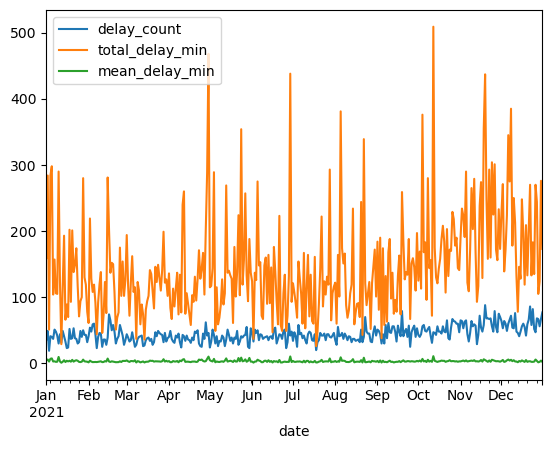

In [317]:
delay_summary.plot()

To create a separate plot for each column, we can specify `subplots=True`

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

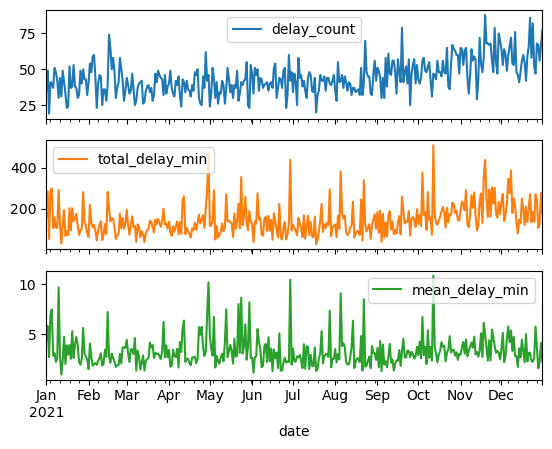

In [318]:
delay_summary.plot(subplots=True)

We can plot other aggregations too. Below, we use `line_groups` and calculate the size of each group, i.e., the number of delays reported on each line. Then we plot the data, telling `pandas` that the plot `kind` should be a bar graph, with TTC lines should in the `x`-axis. We also pass in a title.

<Axes: title={'center': 'Delays by Subway Line, 2021'}, xlabel='line'>

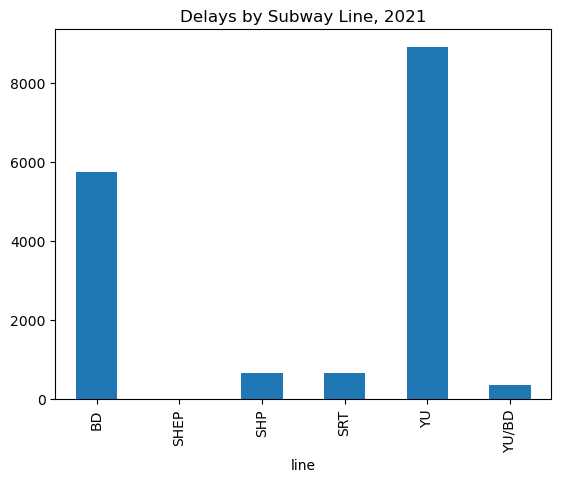

In [319]:
(line_groups
 .size()
 .plot(x='line',
       kind='bar',
       title='Delays by Subway Line, 2021'))

It is possible to sum up and plot the total delay time, in hours, by line.

<Axes: xlabel='line'>

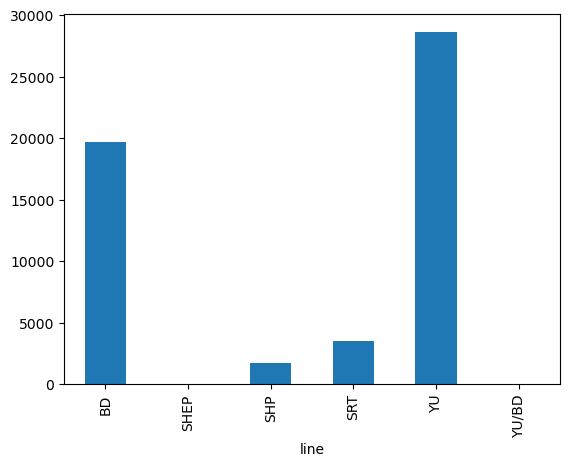

In [320]:
(delays_w_reasons
 .groupby('line')['min_delay']
 .sum()
 .plot(x='line', kind='bar'))

# Writing to file

## Exporting DataFrames

DataFrames have `to_[file format]()` methods, analagous to `pandas` read functions. The counterpart to `pd.read_csv()`, for instance, is `DataFrame.to_csv()`. The export methods generally take a file path to save to as their first argument. Additional arguments vary a bit by export format, but `index` is a common useful one. It takes a boolean of whether to write the index to file -- set it to `False` if the index is the numbered default.

Two additional useful parameters in `DataFrame.to_csv()` and `DataFrame.to_excel()` are `na_rep`, which takes a string to use for null values, and `columns`, which lets us write out a subset of columns.

In [322]:
# write delays_w_reasons to an Excel file
delays_w_reasons.to_excel('C:/Users/jcp_2/python/05_src/data/slides_data/ttc_subway_delays_w_reasons.xlsx', index=False)

# References

### Programming
- pandas development team. _API reference_. https://pandas.pydata.org/pandas-docs/stable/reference/index.html
- pandas development team. _User guide_. https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html
- _Python strftime cheatsheet_. https://strftime.org/


### Data Sources
- Open Data Toronto. _Neighbourhood Profiles_. https://open.toronto.ca/dataset/neighbourhood-profiles/
- Open Data Toronto. _TTC Subway Delay Data_. https://open.toronto.ca/dataset/ttc-subway-delay-data/
- Open Data Toronto. _Bicyle Thefts_. https://open.toronto.ca/dataset/bicycle-thefts/